<a href="https://colab.research.google.com/github/Anik-1802021/ML-Autoencoder-denoise-custom-dataset/blob/main/Denoise_Autoencoder_custom_dataset_v_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Epoch 1/20
29/29 [==============================] - 7s 184ms/step - loss: 0.5387 - val_loss: 0.4546
Epoch 2/20
29/29 [==============================] - 4s 148ms/step - loss: 0.4342 - val_loss: 0.3926
Epoch 3/20
29/29 [==============================] - 4s 146ms/step - loss: 0.4019 - val_loss: 0.3816
Epoch 4/20
29/29 [==============================] - 4s 140ms/step - loss: 0.3920 - val_loss: 0.3755
Epoch 5/20
29/29 [==============================] - 4s 141ms/step - loss: 0.3878 - val_loss: 0.3734
Epoch 6/20
29/29 [==============================] - 4s 146ms/step - loss: 0.3861 - val_loss: 0.3720
Epoch 7/20
29/29 [==============================] - 4s 136ms/step - loss: 0.3847 - val_loss: 0.3705
Epoch 8/20
29/29 [==============================] - 4s 140ms/step - loss: 0.3833 - val_loss: 0.3694
Epoch 9/20
29/29 [==============================] - 4s 142ms/step - loss: 0.3822 - val_loss: 0.3685
Epoch 10/20
29/29 [==============================] - 4s 150ms/step - loss: 0.3812 - val_loss: 0.3676

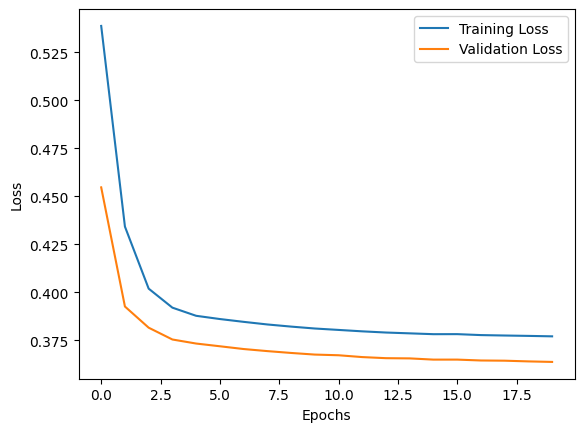

4/4 [==============================] - 0s 84ms/step


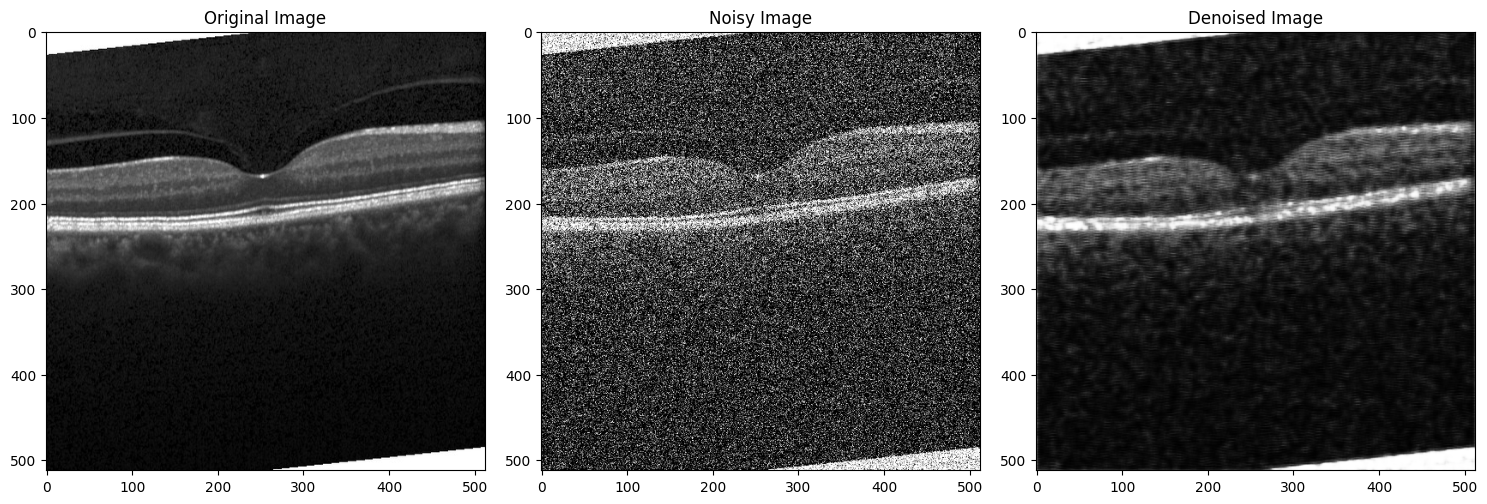

PSNR between original and noisy image: 10.78848593698013
MSE between original and noisy image: 0.08339718781365832
SSIM between original and noisy image: 0.06730557622919664
CNR between original and noisy image: 0.18631485760219793
PSNR between original and denoised image: 10.81352502076448
MSE between original and denoised image: 0.08291775
SSIM between original and denoised image: 0.7045080032638735
CNR between original and denoised image: 0.015200430906418044


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import cv2
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # As the pixel values are normalized to [0, 1]
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate MSE
def mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

# Function to calculate SSIM
def calculate_ssim(img1, img2):
    img1 = img1.squeeze()  # Remove channel dimension for SSIM calculation
    img2 = img2.squeeze()
    ssim_value, _ = ssim(img1, img2, full=True)
    return ssim_value

# Function to calculate CNR (simple implementation)
def calculate_cnr(img1, img2):
    mean1, std1 = cv2.meanStdDev(img1)
    mean2, std2 = cv2.meanStdDev(img2)
    cnr_value = abs(mean1 - mean2) / (std1 + std2)
    return cnr_value[0][0]

# Function to load and preprocess images
def load_images_from_folder(folder, image_size=(512, 512)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = plt.imread(img_path, format='grayscale')  # Load image in grayscale
            img = img / 255.0  # Normalize pixel values to [0, 1]
            img = img.astype('float32')
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            img = np.resize(img, image_size)  # Resize image to specified dimensions
            images.append(img)
    images = np.array(images)
    return images

# Load images from the specified dataset folder
dataset_folder = '/content/drive/MyDrive/Thisis/custom_dataset/train/NORMAL'
image_size = (512, 512)
images = load_images_from_folder(dataset_folder, image_size)

# Split data into training and test sets
x_train = images[:int(0.8 * len(images))]
x_test = images[int(0.8 * len(images)):]

# Add noise to the data
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Define the denoising autoencoder model
def denoising_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
    # Decoder
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    up1 = UpSampling2D((2, 2))(conv2)
    # Output
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up1)
    model = Model(inputs, outputs)
    return model

# Create and compile the denoising autoencoder model
input_shape = (image_size[0], image_size[1], 1)
denoise_model = denoising_autoencoder(input_shape)
denoise_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = denoise_model.fit(x_train_noisy, x_train, epochs=20, batch_size=16, validation_data=(x_test_noisy, x_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
denoised_images = denoise_model.predict(x_test_noisy)

# Display one original, noisy, and denoised image each
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(x_test[0], cmap='gray')
plt.title('Original Image')

# Noisy Image
plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[0], cmap='gray')
plt.title('Noisy Image')

# Denoised Image
plt.subplot(1, 3, 3)
plt.imshow(denoised_images[0], cmap='gray')
plt.title('Denoised Image')

plt.tight_layout()
plt.show()

# Calculate PSNR, MSE, SSIM, and CNR between original and noisy image
psnr_noisy = psnr(x_test[0], x_test_noisy[0])
mse_noisy = mse(x_test[0], x_test_noisy[0])
ssim_noisy = calculate_ssim(x_test[0], x_test_noisy[0])
cnr_noisy = calculate_cnr(x_test[0], x_test_noisy[0])
print("PSNR between original and noisy image:", psnr_noisy)
print("MSE between original and noisy image:", mse_noisy)
print("SSIM between original and noisy image:", ssim_noisy)
print("CNR between original and noisy image:", cnr_noisy)

# Calculate PSNR, MSE, SSIM, and CNR between original and denoised image
psnr_denoised = psnr(x_test[0], denoised_images[0])
mse_denoised = mse(x_test[0], denoised_images[0])
ssim_denoised = calculate_ssim(x_test[0], denoised_images[0])
cnr_denoised = calculate_cnr(x_test[0], denoised_images[0])
print("PSNR between original and denoised image:", psnr_denoised)
print("MSE between original and denoised image:", mse_denoised)
print("SSIM between original and denoised image:", ssim_denoised)
print("CNR between original and denoised image:", cnr_denoised)
